In [1]:
import torch
import torchvision
import construct
import prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
class myModel(torch.nn.Module):
    def __init__(self):
        """
        Initializes CNN. Here we just define layer shapes that we call in the forward func
        """
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5,
                                    bias = False)
                
        #Convultion layer 2. See above
        self.conv2 = torch.nn.Conv2d(in_channels = 6, 
                               out_channels = 12, 
                               kernel_size = 5,
                                    bias = False)
        
        self.fc_1 = torch.nn.Linear(39 * 39 * 12, 256)
        self.fc_2 = torch.nn.Linear(256, 2)
        self.drop = torch.nn.Dropout(p=.2)
        self.batch1 = torch.nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch2 = torch.nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            
    def forward(self, x):
        """
        Function that performs all the neural network forward calculation i.e.
        takes image data from the input of the neural network to the output
        """
        
        x = self.conv1(x)
        x = self.batch1(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 2)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 4)
        x = torch.nn.functional.leaky_relu(x)
        x = x.view(x.shape[0], -1)  
        x = self.fc_1(x) 
        x = torch.nn.functional.leaky_relu(x)
        x = self.drop(x)
        x = self.fc_2(x) 
        return x

model = myModel()

In [3]:
k = 5
epochs = 250
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.RandomRotation((-180,180)),
                            torchvision.transforms.CenterCrop((325)),
                            torchvision.transforms.ToTensor()
                                      ])
image_dir = 'will/data/raman_images'
labels_file = 'will/data/labels.csv'
DATA = prep.prep_data(pd.read_csv(labels_file), image_dir)
transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.RandomRotation((-180,180)),
                            torchvision.transforms.CenterCrop((325)),
                            torchvision.transforms.ToTensor()
                                      ])
optimizer = torch.optim.Adam(model.parameters(), lr=.001)


x = construct.k_fold(k, epochs, BATCH_SIZE, transforms, criterion, model, DATA, device, image_dir)
(models, losses, train_accs, naive_accs, test_accs) = x

/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/prep.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = False
/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/prep.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = True


EPOCH: 0, acc: 0.674679485651163, loss: 0.633450801555927
EPOCH: 1, acc: 0.6778846153846154, loss: 0.6326699073498065
EPOCH: 2, acc: 0.6770833318050091, loss: 0.6374962284014776
EPOCH: 3, acc: 0.6738782066565293, loss: 0.6298320522675147
EPOCH: 0, acc: 0.6958653835149912, loss: 0.6160778815929706
EPOCH: 1, acc: 0.7023076919408945, loss: 0.6190303151424115
EPOCH: 2, acc: 0.6958653835149912, loss: 0.6120806428102347
EPOCH: 3, acc: 0.700961539378533, loss: 0.6073171909038837
EPOCH: 0, acc: 0.6728846155680143, loss: 0.640074936243204
EPOCH: 1, acc: 0.6725000005501968, loss: 0.6309212423287905
EPOCH: 2, acc: 0.6728846155680143, loss: 0.6453300370619848
EPOCH: 3, acc: 0.6745192316862253, loss: 0.6276172812168415
EPOCH: 0, acc: 0.6869230774732736, loss: 0.6161148571051084
EPOCH: 1, acc: 0.6879807710647583, loss: 0.6197612698261554
EPOCH: 2, acc: 0.6879807710647583, loss: 0.6213852946574872
EPOCH: 3, acc: 0.6882692300356351, loss: 0.6309732794761658
EPOCH: 0, acc: 0.6810576915740967, loss: 0.6

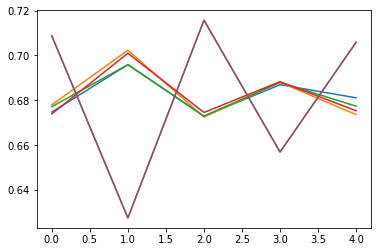

In [7]:
plt.plot(train_accs)
plt.plot(naive_accs)
plt.plot(test_accs)